In [1]:
import pandas as pd
import numpy as np
import zipfile
from matplotlib import pyplot as plt
import  matplotlib
from IPython import display
import seaborn as sns
import warnings
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LinearRegression

import re

import sys

sys.path.append("../tool/")

import preprocess
import visualization

In [2]:
data = pd.read_csv("../data/clean_data.csv")

In [3]:
data.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_total,host_seattle,host_verifications_total,host_since_period
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,False,moderate,False,False,2,4.07,11,True,5,1607
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,False,strict,True,True,6,1.48,17,True,7,1047
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,False,strict,False,False,2,1.15,22,True,6,571


In [4]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
if False:
    # extra the price and the cleaning_fee values from string
    columns = [
        "price",
        "weekly_price",
        "monthly_price",
        "cleaning_fee",
        "security_deposit",
        "extra_people"
    ]
    for column in columns:
        data[column] = preprocess.parse_money(data, column)

    data.property_type.fillna("House", inplace=True)

    # convert the datatype as timestamp
    columns = [
        "first_review",
        "last_review",
        "host_since",
        "calendar_last_scraped",
        "last_scraped"
    ]
    for column in columns:
        data[column] = pd.to_datetime(data[column])

    # replace the invalidate identifier in host_acceptance_rate
    data["host_response_rate"] = data["host_response_rate"].str.replace("%", "").astype("float16")
    data["host_acceptance_rate"] = data["host_acceptance_rate"].str.replace("%", "").astype("float16")

    # replace the invalidate identifier in host_verifications
    data["host_verifications"] = data["host_verifications"].str.replace("\[\]", "0")
    data["host_verifications"] = data["host_verifications"].str.replace("\[|\]", "")
    data.loc[:, "host_verifications"] = np.where(data["host_verifications"] == "0", np.repeat(np.nan, data.shape[0]), data.host_verifications)

    # replace the invalidate identifier in amenities
    data.loc[:, "amenities"] = data.amenities.str.replace("\{\}", "0")
    data.loc[:, "amenities"] = data.amenities.str.replace('\{|\}|"', "")
    data.loc[:, "amenities"] = np.where(data.amenities == "0", np.repeat(np.nan, data.shape[0]), data.amenities)

    # https://www.airbnb.cn/help/article/828/what-is-a-superhost?ibbe=0
    # convert the values which are boolean
    columns = [
        "require_guest_profile_picture",
        "require_guest_phone_verification",
        "has_availability",
        "requires_license",
        "instant_bookable",
        "is_location_exact",
        "host_is_superhost", 
        "host_has_profile_pic",
        "host_identity_verified"
    ]

    data.loc[:, columns] = data.loc[:, columns].applymap(lambda x: True if x == "t" else False if x=="f" else x)

    data.loc[:, "zipcode"].replace("99\n98122", "98122", inplace=True)

In [6]:
data.availability_365.value_counts(dropna=False).sort_index(ascending=False)

365    678
364     91
363     44
362     51
361     53
360     42
359     44
358     51
357     42
356     41
355     31
354     26
353     27
352     34
351     35
350     26
349     16
348     19
347     25
346     14
345     23
344     23
343     16
342     18
341     16
340     23
339      8
338     29
337     42
336     25
      ... 
29       7
28       9
27       9
26       3
25       3
24       2
23       2
22       5
21       8
20      12
19       6
18       3
17       4
16       8
15       5
14       6
13       3
12       1
11       6
10       4
9        6
8        5
7        3
6        5
5       10
4        5
3        7
2       32
1        7
0       95
Name: availability_365, Length: 363, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816 entries, 0 to 3815
Data columns (total 94 columns):
id                                  3816 non-null int64
listing_url                         3816 non-null object
scrape_id                           3816 non-null int64
last_scraped                        3816 non-null object
name                                3816 non-null object
summary                             3639 non-null object
space                               3248 non-null object
description                         3816 non-null object
experiences_offered                 3816 non-null object
neighborhood_overview               2785 non-null object
notes                               2211 non-null object
transit                             2883 non-null object
thumbnail_url                       3496 non-null object
medium_url                          3496 non-null object
picture_url                         3816 non-null object
xl_picture_url                      3496

In [8]:
data.select_dtypes(include=["object"]).isnull().sum()

listing_url                        0
last_scraped                       0
name                               0
summary                          177
space                            568
description                        0
experiences_offered                0
neighborhood_overview           1031
notes                           1605
transit                          933
thumbnail_url                    320
medium_url                       320
picture_url                        0
xl_picture_url                   320
host_url                           0
host_name                          0
host_since                         0
host_location                      6
host_about                       857
host_response_time               521
host_thumbnail_url                 0
host_picture_url                   0
host_neighbourhood                 0
host_verifications                 1
street                             0
neighbourhood                      0
neighbourhood_cleansed             0
n

## Analysis the Property Type

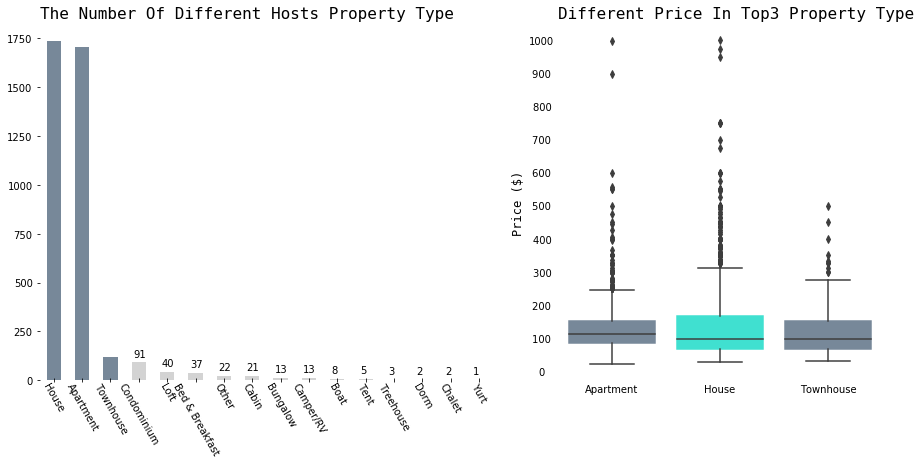

In [9]:
fig = plt.figure(1, figsize=(9, 8*.618))

# setup the subplots
ax1 = plt.axes([0, .2, .7, 1])
ax2 = plt.axes([0.8, .2, 0.5, 1])

property_type_count = data.property_type.value_counts() 
property_type_value = property_type_count.apply(lambda x: x if x < 100 else 0)
proptery_type_color = property_type_count.apply(lambda x: "lightgray" if x < 100 else "lightslategray")

# ax1.bar()

property_type_count.plot(kind="bar", ax=ax1, color=proptery_type_color, rot=300)

for index, value in enumerate(property_type_value):
    if value:
        ax1.text(index-0.2, value+30, value, fontsize=10)
    
ax1.set_title("The Number Of Different Hosts Property Type", fontsize=16, family="monospace", loc="left")
ax1.tick_params(axis="x",  pad=-0.7, direction="inout")

# plot boxplot
sns.boxplot(
    data=data.loc[data.property_type.apply(lambda x: x in property_type_count.nlargest(3)), :],
    x="property_type", y="price", ax=ax2, 
)

# set patches color
colors = ["lightslategray", "turquoise", "lightslategray"]
for patch, color in zip(ax2.axes.artists, colors):
    patch.set_color(color)

ax2.set_yticks(np.arange(0, 1100, 100))

formater = matplotlib.ticker.FormatStrFormatter("%-4d")
ax2.yaxis.set_major_formatter(formater)

ax2.set_title("Different Price In Top3 Property Type", fontsize=16, family="monospace", loc="left")
ax2.set_xlabel("")
ax2.set_ylabel("Price ($)", fontsize=12, family="monospace")
ax2.tick_params(labelsize=10, length=0)
    
# set spines
for spine in ["top", "left", "right", "bottom"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
plt.show()

## Analysis The amenities

In [10]:
# parse the amentities option
amenities_set = set()
for i in data["amenities"]:
    if pd.notnull(i):
        amenities_set |= set(i.split(","))

amenities_set = list(amenities_set)

amenities = data.amenities.value_counts().reset_index()
amenities.rename({"index":"amenity", "amenities": "count"}, inplace=True, axis=1)

amenities_count = preprocess.option_count(amenities, "amenity", "count", amenities_set)

# sort by count value
amenities_count.sort_values("count", inplace=True)

In [11]:
print("There are {} amenities served by the hosts".format(amenities_count.amenity.nunique()))


There are 41 amenities served by the hosts


In [12]:
amenities_count[amenities_count["count"] > 3000].sort_values("count")

,amenity,count
23,Dryer,3112
5,Essentials,3236
34,Smoke Detector,3280
19,Kitchen,3421
4,Heating,3625
3,Wireless Internet,3665
14,Internet,3690


In [13]:
display.display_html(
    "<p style='font: italic 25px Fira Sans, serif;'> \
        The median of amenity is {:0.0f}. \
    </p>".format(amenities_count["count"].quantile()),
    raw=True)


The median of amenity is 773.

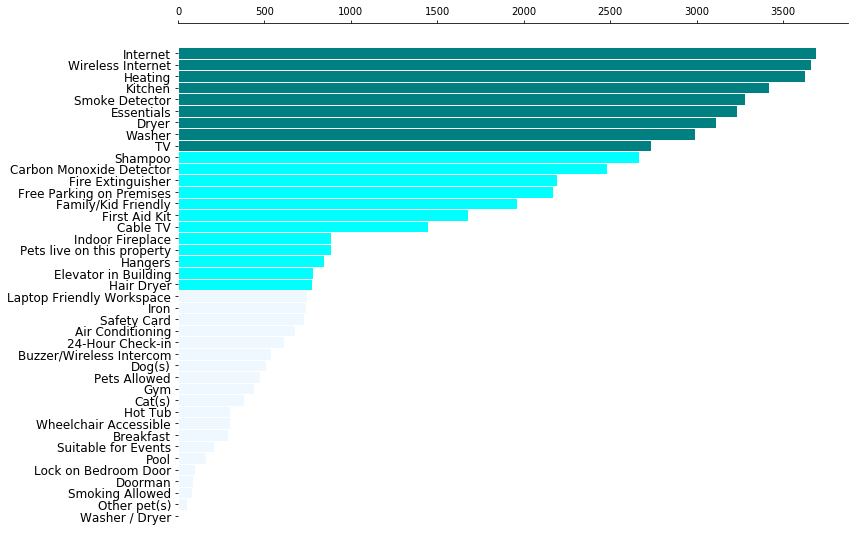

In [14]:
plt.figure(figsize=(12, 12*.8))
ax = plt.subplot()
# amenities_count.plot(kind="barh", y="count", x="amenity", ax=ax, )
colors = amenities_count["count"].apply(
    lambda x: "teal" if x >= amenities_count["count"].quantile(.8) 
    else "aqua" if x >= amenities_count["count"].quantile(.49) else "aliceblue"
)

ax.barh(
    y=amenities_count["amenity"], width=amenities_count["count"],
    height=1, color=colors, edgecolor="white", align="center"
)
# set the top xticks
ax.xaxis.tick_top()
ax.yaxis.set_tick_params(labelsize=12)
# set spines
for spine in [ "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
plt.show()

In [15]:
from imp import reload
reload(visualization)

<module 'visualization' from '../tool/visualization.py'>

In [16]:
# parse the amenities information according to the three level rank
targets = [
    "amenity_internet",
    "amenity_heating",
    "amenity_kitchen",
    "amenity_elevator",
    "amenity_hanger",
    "amenity_kid",
    "amenity_doorman",
    "amenity_smoking"
]
amenitiy_options = [
    "Internet",
    "Heating",
    "Kitchen",
    "Elevator",
    "Hangers",
    "Family/Kid Friendly",
    "Doorman",
    "Smoking Allowed"
]



# concate the dataframe by different amenity
amenities_concate = pd.DataFrame()
calculate_columns = ["price", "number_of_reviews"]

for target, amenity in zip(targets, amenitiy_options):
    visualization.parse_amenity(data, amenity, target, inplace=True, silence=True)
    tem = visualization.group_for_concat(
        data, target, calculate_columns, np.mean, 
        by_value=amenity
      )
    amenities_concate = pd.concat([amenities_concate, tem], ignore_index=True)

# change the condition value
amenities_concate["condition"] = amenities_concate["condition"].apply(lambda x: "Served" if x else "NonServed")

In [17]:
amenities_concate.head(3)

,type,condition,variable,value
0,Internet,NonServed,price,109.839506
1,Internet,Served,price,128.349051
2,Internet,NonServed,number_of_reviews,11.506173


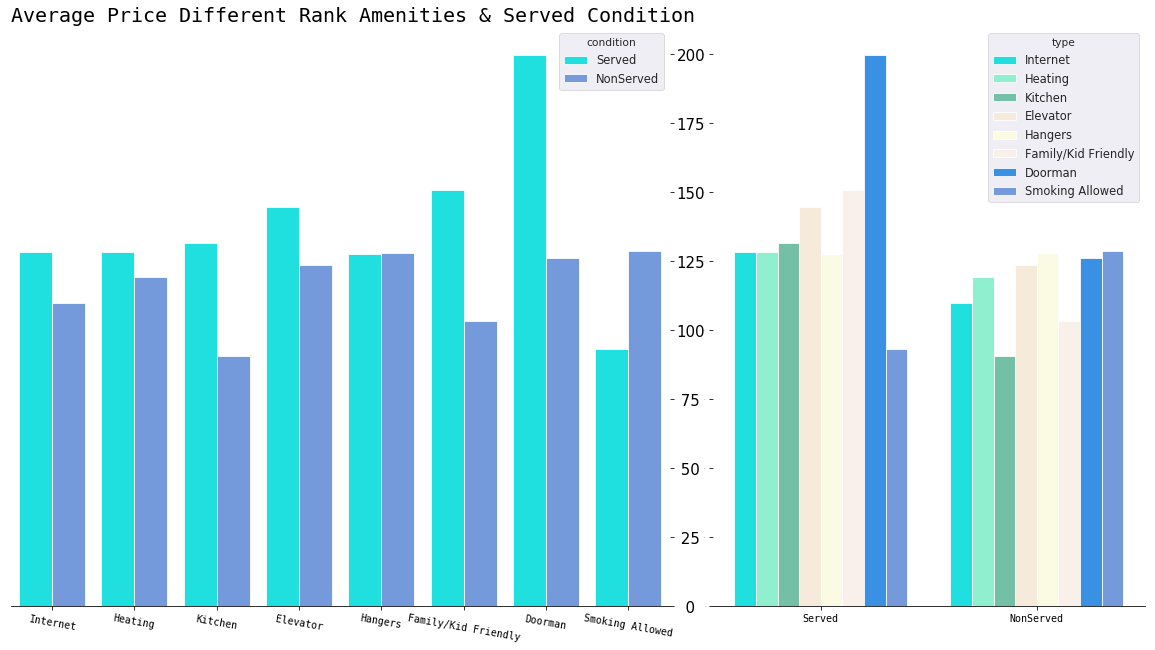

In [18]:
fig = plt.figure(1, figsize=(15, 13*.618))
colors = [
    "aqua",
    "aquamarine",
    "mediumaquamarine",    #"mediumspringgreen",
    "antiquewhite",
    "lightyellow",
    "linen",
    "dodgerblue", #"darkblue", #    "lightskyblue",
    "cornflowerblue", #"cadetblue", #"deepskyblue",
]
# setup the subplots
ax1 = plt.axes([0, .2, .61, 1])
ax2 = plt.axes([0.65, .2, 0.4, 1])

with sns.axes_style("darkgrid"), sns.plotting_context("paper", font_scale=1.3):
    sns.set_palette([colors[0], colors[-1]])
    sns.barplot(x="type", y="value", hue_order=["Served", "NonServed"],
                hue="condition",data=amenities_concate.query("variable=='price'"), ax=ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.yaxis.tick_right()
    ax1.yaxis.set_tick_params(labelsize=15)
    ax1.xaxis.set_tick_params(labelsize=10)
    ax1.xaxis.set_ticklabels(ax1.xaxis.get_ticklabels(), family="monospace", rotation=350)
    ax1.set_title("Average Price Different Rank Amenities & Served Condition", 
                  fontsize=20, family="monospace", loc="left")
    
    formater = matplotlib.ticker.FormatStrFormatter("%3d")
    ax1.yaxis.set_major_formatter(formater)
    
    
    sns.set_palette(colors)
    sns.barplot(x="condition", y="value", hue_order=amenitiy_options, order=["Served", "NonServed"],
                hue="type", data=amenities_concate.query("variable=='price'"), ax=ax2)
    ax2.set_xlabel("")
    ax2.set_ylabel("")

    ax2.yaxis.set_tick_params(labelsize=0, length=4)
    ax2.tick_params(axis="y", direction="out")
    ax2.xaxis.set_ticklabels(ax2.xaxis.get_ticklabels(), family="monospace")
    ax2.xaxis.set_tick_params(labelsize=10)    
    
    for spine in ["top", "left", "right"]:
        ax1.spines[spine].set_visible(False)
        ax2.spines[spine].set_visible(False)

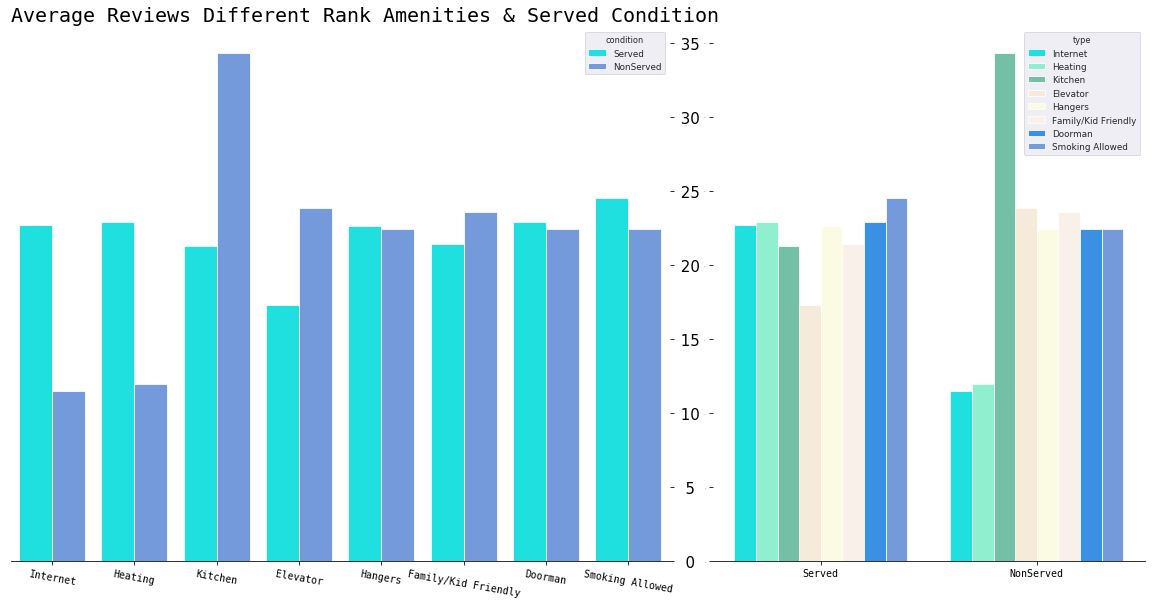

In [20]:
fig = plt.figure(1, figsize=(15, 12*.618))
colors = [
    "aqua",
    "aquamarine",
    "mediumaquamarine",    #"mediumspringgreen",
    "antiquewhite",
    "lightyellow",
    "linen",
    "dodgerblue", #"darkblue", #    "lightskyblue",
    "cornflowerblue", #"cadetblue", #"deepskyblue",
]
# setup the subplots
ax1 = plt.axes([0, .3, .61, 1])
ax2 = plt.axes([0.65, .3, 0.4, 1])

with sns.axes_style("darkgrid"), sns.plotting_context("paper", font_scale=1):
    sns.set_palette([colors[0], colors[-1]])
    sns.barplot(x="type", y="value", hue_order=["Served", "NonServed"],
                hue="condition",data=amenities_concate.query("variable=='number_of_reviews'"), ax=ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.yaxis.tick_right()
    ax1.yaxis.set_tick_params(labelsize=15)
    ax1.xaxis.set_tick_params(labelsize=10)
    ax1.xaxis.set_ticklabels(ax1.xaxis.get_ticklabels(), family="monospace", rotation=350)
    ax1.set_title("Average Reviews Different Rank Amenities & Served Condition", 
                  fontsize=20, family="monospace", loc="left")
    
    formater = matplotlib.ticker.FormatStrFormatter("%3d")
    ax1.yaxis.set_major_formatter(formater)
    
    
    sns.set_palette(colors)
    sns.barplot(x="condition", y="value", hue_order=amenitiy_options, order=["Served", "NonServed"],
                hue="type", data=amenities_concate.query("variable=='number_of_reviews'"), ax=ax2)
    ax2.set_xlabel("")
    ax2.set_ylabel("")

    ax2.yaxis.set_tick_params(labelsize=0, length=4)
    ax2.tick_params(axis="y", direction="out")
    ax2.xaxis.set_ticklabels(ax2.xaxis.get_ticklabels(), family="monospace")
    ax2.xaxis.set_tick_params(labelsize=10)
    for spine in ["top", "left", "right"]:
        ax1.spines[spine].set_visible(False)
        ax2.spines[spine].set_visible(False)

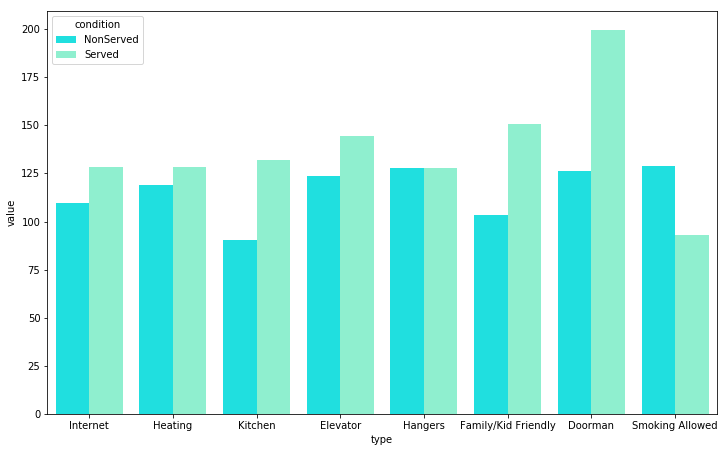

In [20]:
plt.figure(figsize=(12, 12*.618))
sns.barplot(x="type", y="value", hue="condition", data=amenities_concate.query("variable=='price'"));

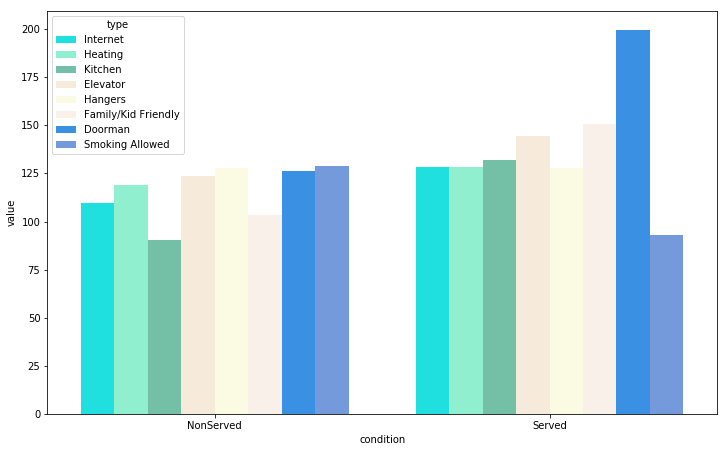

In [21]:
plt.figure(figsize=(12, 12*.618))
sns.barplot(x="condition", y="value", hue="type", data=amenities_concate.query("variable=='price'"));

In [22]:
data.groupby("amenity_internet")[["price", "reviews"]].apply(np.mean).reset_index()

,amenity_internet,price,reviews
0,False,109.839506,38.416481
1,True,128.349051,56.378976


In [23]:
data.groupby("amenity_heating")["price", "reviews"].mean()

,price,reviews
amenity_heating,,
False,119.184932,42.398113
True,128.304552,56.546185


In [24]:
data.reviews_per_month

0       4.07
1       1.48
2       1.15
3        NaN
4       0.89
5       2.45
6       2.46
7       4.73
8       1.22
9       1.55
10      3.33
11      0.98
12      0.92
13      3.00
14      2.65
15      0.73
16      4.55
17      4.58
18       NaN
19      0.82
20      1.00
21      0.71
22      0.86
23       NaN
24      0.18
25      1.30
26       NaN
27      4.38
28      2.47
29      0.33
        ... 
3786    3.39
3787    2.14
3788    3.77
3789    2.48
3790     NaN
3791    4.28
3792    3.10
3793    1.18
3794    5.57
3795    1.00
3796    5.95
3797    1.06
3798     NaN
3799    2.05
3800     NaN
3801    4.00
3802    2.34
3803    3.95
3804    0.24
3805    0.78
3806    1.15
3807    1.18
3808    1.56
3809    0.63
3810    4.01
3811    0.30
3812    2.00
3813     NaN
3814     NaN
3815     NaN
Name: reviews_per_month, Length: 3816, dtype: float64

(0, 150)

<Figure size 864x533.952 with 0 Axes>

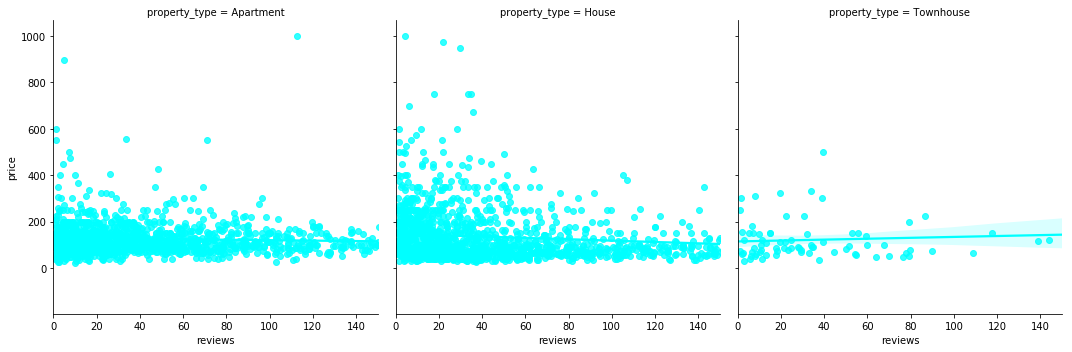

In [25]:

plt.figure(figsize=(12, 12*.618))
# Temporarily Suppressing Warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.lmplot(
        x="reviews", y="price", col="property_type", x_jitter=0.2, y_jitter=0.2,
        data=data.loc[data.property_type.apply(lambda x: x in property_type_count.nlargest(3)), :]
    )
plt.xlim(0, 150)

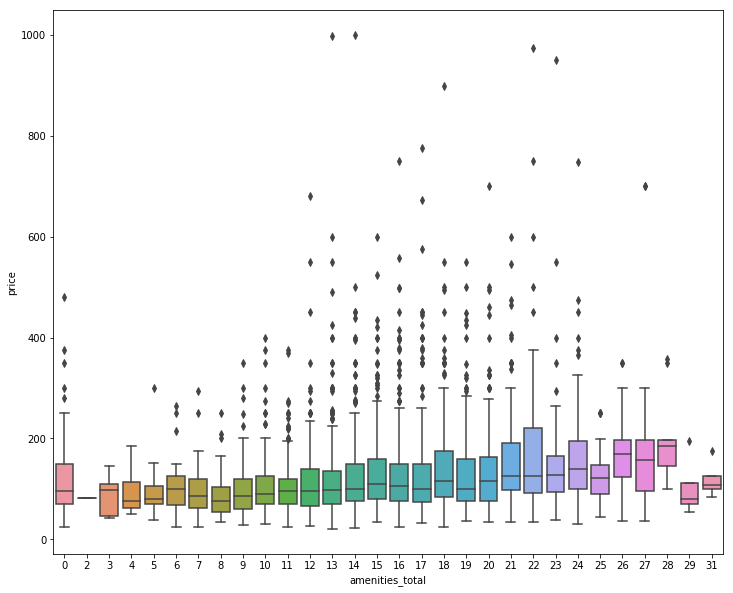

In [26]:
plt.figure(figsize=(12, 10))
sns.boxplot(x="amenities_total", y="price", data=data)
plt.show()